In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lab4_hmc as hmc
%matplotlib inline

In [2]:
from scipy import stats

# Gaussian Example

Text(0, 0.5, 'x2')

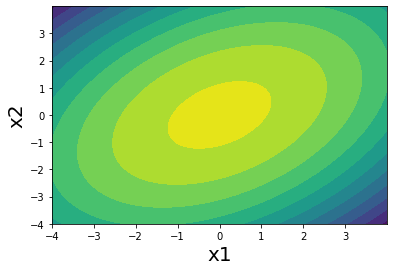

In [3]:
def energy_func(x):
    rv = stats.multivariate_normal(mu, cov)
    return -rv.logpdf(np.dstack((x[0],x[1])))

def energy_grad(x):
    g = np.empty(2)
    
    F = 1/(2*(1-rho**2))
    
    # partial wrt x1 and x2 for bivariate gaussian
    g[0] = (F*( 2*(x[0] - mu[0])/(s0**2) - 2*rho*(x[1] - mu[1])/(s0*s1) ))
    g[1] = (F*( 2*(x[1] - mu[1])/(s1**2) - 2*rho*(x[0] - mu[0])/(s0*s1) ))
    
    return g

x = np.mgrid[-4:4:.01, -4:4:.01]

mu = [0, 0]

s0 = 1.0
s1 = 1.0

rho = 0.4  # correlation
cov = [[s0**2, rho*s0*s1], [rho*s0*s1, s1**2]]
f = 1

z = energy_func(x)
plt.contourf(x[0], x[1], -z, levels = 10)
plt.xlabel('x1', size = 20)
plt.ylabel('x2', size = 20)

In [4]:
x0 = np.random.normal(size=2)
hmc.gradient_check(x0, energy_func, energy_grad)

Calc.         Numeric       Delta         Acc.
   -0.546564     -0.546564   1.655842e-11  11
     1.95781       1.95781   2.435607e-12  12


Calc.         Numeric       Delta         Acc.
   -0.546564     -0.546564   1.655842e-11  11
     1.95781       1.95781   2.435607e-12  12
|----------|  0% accepted [ 7 secs to go ]
|#---------| 81% accepted [ 6 secs to go ]
|##--------| 81% accepted [ 5 secs to go ]
|###-------| 81% accepted [ 5 secs to go ]
|####------| 82% accepted [ 4 secs to go ]
|#####-----| 82% accepted [ 3 secs to go ]
|######----| 82% accepted [ 3 secs to go ]
|#######---| 82% accepted [ 2 secs to go ]
|########--| 82% accepted [ 1 secs to go ]
|#########-| 83% accepted [ 1 secs to go ]
|##########| 83% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=1.1 / Accept=82.9%


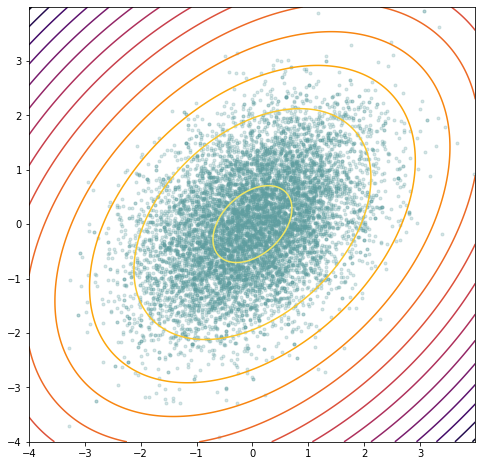

In [5]:
plt.rcParams['figure.figsize'] = [8, 8]
np.random.seed(seed=1)  
R = 10000  
burn = int(R/10) 
L = 25 
eps = 1.1

S, *_ = hmc.sample(x0, energy_func, energy_grad, R, L, eps, 
                   burn=burn, 
                   checkgrad=True, 
                   args=[])

plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(x[0], x[1], -z, cmap = 'inferno', levels = 14)

In [6]:
import pandas as pd
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')

In [7]:
x_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1]
x_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]

In [8]:
def normalize(df, mean_method = True ):
    if mean_method:
        # mean normalization
        normalized_df = (df - df.mean()) / df.std()
        a, b = df.std(), df.mean()
    else:
        # min max normalization
        normalized_df = (df - df.min()) / (df.max() - df.min())
        a, b = df.min(), df.max()
    return normalized_df, a, b

In [9]:
x_train, _, _ = normalize(x_train)
x_test, _, _ = normalize(x_test)

In [10]:
x_train['bias'] = [1]*x_train.shape[0]
x_test['bias'] = [1]*x_test.shape[0]
x_train.shape, x_test.shape

((384, 9), (384, 9))

In [11]:
PHI_train = x_train
PHI_test = x_test 

In [12]:
def compute_posterior(PHI, y, alph, s2):
    #
    #### **** YOUR CODE HERE **** ####
    #
    n_cols = PHI.shape[1]
    Mu = np.linalg.lstsq(PHI.T.dot(PHI) \
                        + s2 * alph * np.eye(n_cols), 
                        PHI.T.dot(y),
                        rcond = -1)
    
    SIGMA = s2 * np.linalg.inv(PHI.T.dot(PHI) + s2*alph*np.eye(n_cols))
    
    return Mu, SIGMA

In [13]:
alph = 1e-3
s2 = 1e-2
Mu, SIGMA= compute_posterior(PHI_train, y_train, alph, s2)
y_post = PHI_test.dot(Mu[0])

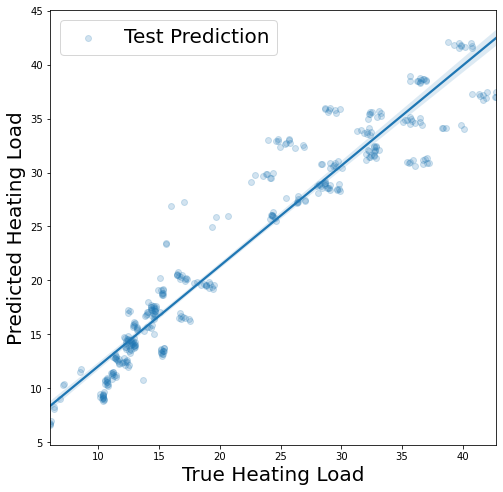

In [14]:
import seaborn as sns
sns.regplot(y_test,y_post, label = 'Test Prediction',scatter_kws={'alpha':0.2})
plt.xlabel('True Heating Load', size = 20)
plt.ylabel('Predicted Heating Load', size = 20)
plt.legend(fontsize = 20)

# HMC applied to linear regression

In [15]:
def energy_func(x, x_train, y_train):
    
    w = x[:9]
    s2 = (x[9])
    alpha = (x[10])
    
    M = x_train.shape[1]
    N = x_train.shape[0]
    
    y_post = x_train @ w
    
    liklihood = -(N/2.0)*np.log( (2.0*np.pi*s2**2) ) \
                - (np.sum((y_train - y_post)**2.0)/(2*s2**2) )
    
    prior = (M/2.0)*np.log( (alpha/(2.0*np.pi)) ) \
            - ((alpha/2)*np.sum(w**2.0))
    
    return -(liklihood + prior)


def energy_grad(x, x_train, y_train):
    
    # define empty array
    g = np.empty(11)
    
    # collect weights, noise, and alpha parameters
    w = x[:9]
    s2 = (x[9])
    alpha = (x[10])
    
    M = x_train.shape[1]
    N = x_train.shape[0]
    
    y_post = x_train @ w
    
    # compute gradient for each weight in loop
    for i in range(x_train.shape[1]): # grad weights W
        g[i] = -np.sum( x_train[:,i]*(y_train - y_post) ) / (s2**2)  + alpha*w[i]
    
    # compute noise and alpha gradients respectivly
    g[9] = N/(s2) - (np.sum((y_train - y_post)**2.0) / (s2**3) ) # grad noise (s2)
    g[10] = (-M/(2*alpha) + np.sum(0.5*w**2.0)) # grad alpha
    
    return g

#x = np.mgrid[-4:4:.01, -4:4:.01]

#z = energy_func(x)
#plt.contourf(x[0], x[1], -z, levels = 10)

In [16]:
np.random.seed(seed=1000)    #1000
x0 = np.random.uniform(0.001,1,size=11)

# intitial guess for s2 and alpha are on a different scale
#x0[-2:] = np.random.uniform(1,1e3,size=2)
print(x0)

hmc.gradient_check(x0, energy_func, energy_grad, x_train.values, y_train.values)

[0.653936   0.11589194 0.95033258 0.48270921 0.87260206 0.21312035
 0.04166892 0.39779727 0.23389907 0.84189898 0.20787526]
Calc.         Numeric       Delta         Acc.
    -3002.32      -3002.32   1.004266e-05   9
     3213.57       3213.57  -4.521134e-06   9
    -1875.69      -1875.69  -9.730793e-06   9
     4043.12       4043.12  -2.760729e-06  10
    -4212.29      -4212.29  -4.588359e-06   9
    -13.9725      -13.9725  -4.181762e-06   7
    -1340.51      -1340.51  -1.207920e-05   9
    -151.994      -151.994   2.286194e-06   8
    -12290.9      -12290.9  -1.107603e-05  10
     -382201       -382201  -3.084424e-06  12
    -20.3482      -20.3482   5.035713e-06   7


In [17]:
R = 10000  
burn = int(R/10) 
L = 100
eps = 0.00250

#0.030 # s2,alpha - uniform(1,1e3)
#0.00195 # uniform (0,1)

S, R = hmc.sample(x0, energy_func, energy_grad, R, L, eps, 
                   burn=burn, 
                   checkgrad=True, 
                   args=[x_train.values, y_train.values])

Calc.         Numeric       Delta         Acc.
    -3002.32      -3002.32   1.004266e-05   9
     3213.57       3213.57  -4.521134e-06   9
    -1875.69      -1875.69  -9.730793e-06   9
     4043.12       4043.12  -2.760729e-06  10
    -4212.29      -4212.29  -4.588359e-06   9
    -13.9725      -13.9725  -4.181762e-06   7
    -1340.51      -1340.51  -1.207920e-05   9
    -151.994      -151.994   2.286194e-06   8
    -12290.9      -12290.9  -1.107603e-05  10
     -382201       -382201  -3.084424e-06  12
    -20.3482      -20.3482   5.035713e-06   7


C:\Users\jdetu\Google Drive\BATH\Bayesian Machine Learning\Coursework 4 - Final Project-20210511\submission\lab4_hmc.py:121: RuntimeWarning: overflow encountered in exp
  if np.random.uniform() < np.exp(current_U-proposed_U+current_K-proposed_K):
<ipython-input-15-cdb6f0e77974>:15: RuntimeWarning: invalid value encountered in log
  prior = (M/2.0)*np.log( (alpha/(2.0*np.pi)) ) \


|----------|  0% accepted [ 96 secs to go ]
|#---------| 94% accepted [ 84 secs to go ]


<ipython-input-15-cdb6f0e77974>:38: RuntimeWarning: overflow encountered in double_scalars
  g[i] = -np.sum( x_train[:,i]*(y_train - y_post) ) / (s2**2)  + alpha*w[i]
<ipython-input-15-cdb6f0e77974>:41: RuntimeWarning: overflow encountered in square
  g[9] = N/(s2) - (np.sum((y_train - y_post)**2.0) / (s2**3) ) # grad noise (s2)
<ipython-input-15-cdb6f0e77974>:41: RuntimeWarning: overflow encountered in double_scalars
  g[9] = N/(s2) - (np.sum((y_train - y_post)**2.0) / (s2**3) ) # grad noise (s2)
<ipython-input-15-cdb6f0e77974>:41: RuntimeWarning: invalid value encountered in double_scalars
  g[9] = N/(s2) - (np.sum((y_train - y_post)**2.0) / (s2**3) ) # grad noise (s2)
<ipython-input-15-cdb6f0e77974>:42: RuntimeWarning: overflow encountered in square
  g[10] = (-M/(2*alpha) + np.sum(0.5*w**2.0)) # grad alpha
<ipython-input-15-cdb6f0e77974>:13: RuntimeWarning: overflow encountered in square
  - (np.sum((y_train - y_post)**2.0)/(2*s2**2) )
<ipython-input-15-cdb6f0e77974>:16: RuntimeWar

|##--------| 87% accepted [ 74 secs to go ]
|###-------| 84% accepted [ 63 secs to go ]
|####------| 86% accepted [ 54 secs to go ]
|#####-----| 86% accepted [ 45 secs to go ]
|######----| 86% accepted [ 36 secs to go ]
|#######---| 87% accepted [ 27 secs to go ]
|########--| 87% accepted [ 18 secs to go ]
|#########-| 88% accepted [ 9 secs to go ]
|##########| 88% accepted [ 0 secs to go ]
HMC: R=10000 / L=100 / eps=0.00259 / Accept=88.4%


In [18]:
S.mean(axis = 0)

array([-7.42279075e+00, -7.33580835e+00,  2.29119807e+00, -1.14363679e+00,
        7.03680857e+00, -1.26228464e-01,  2.77064732e+00,  2.05836464e-01,
        2.29101651e+01,  3.05392299e+00,  1.44741877e-02])

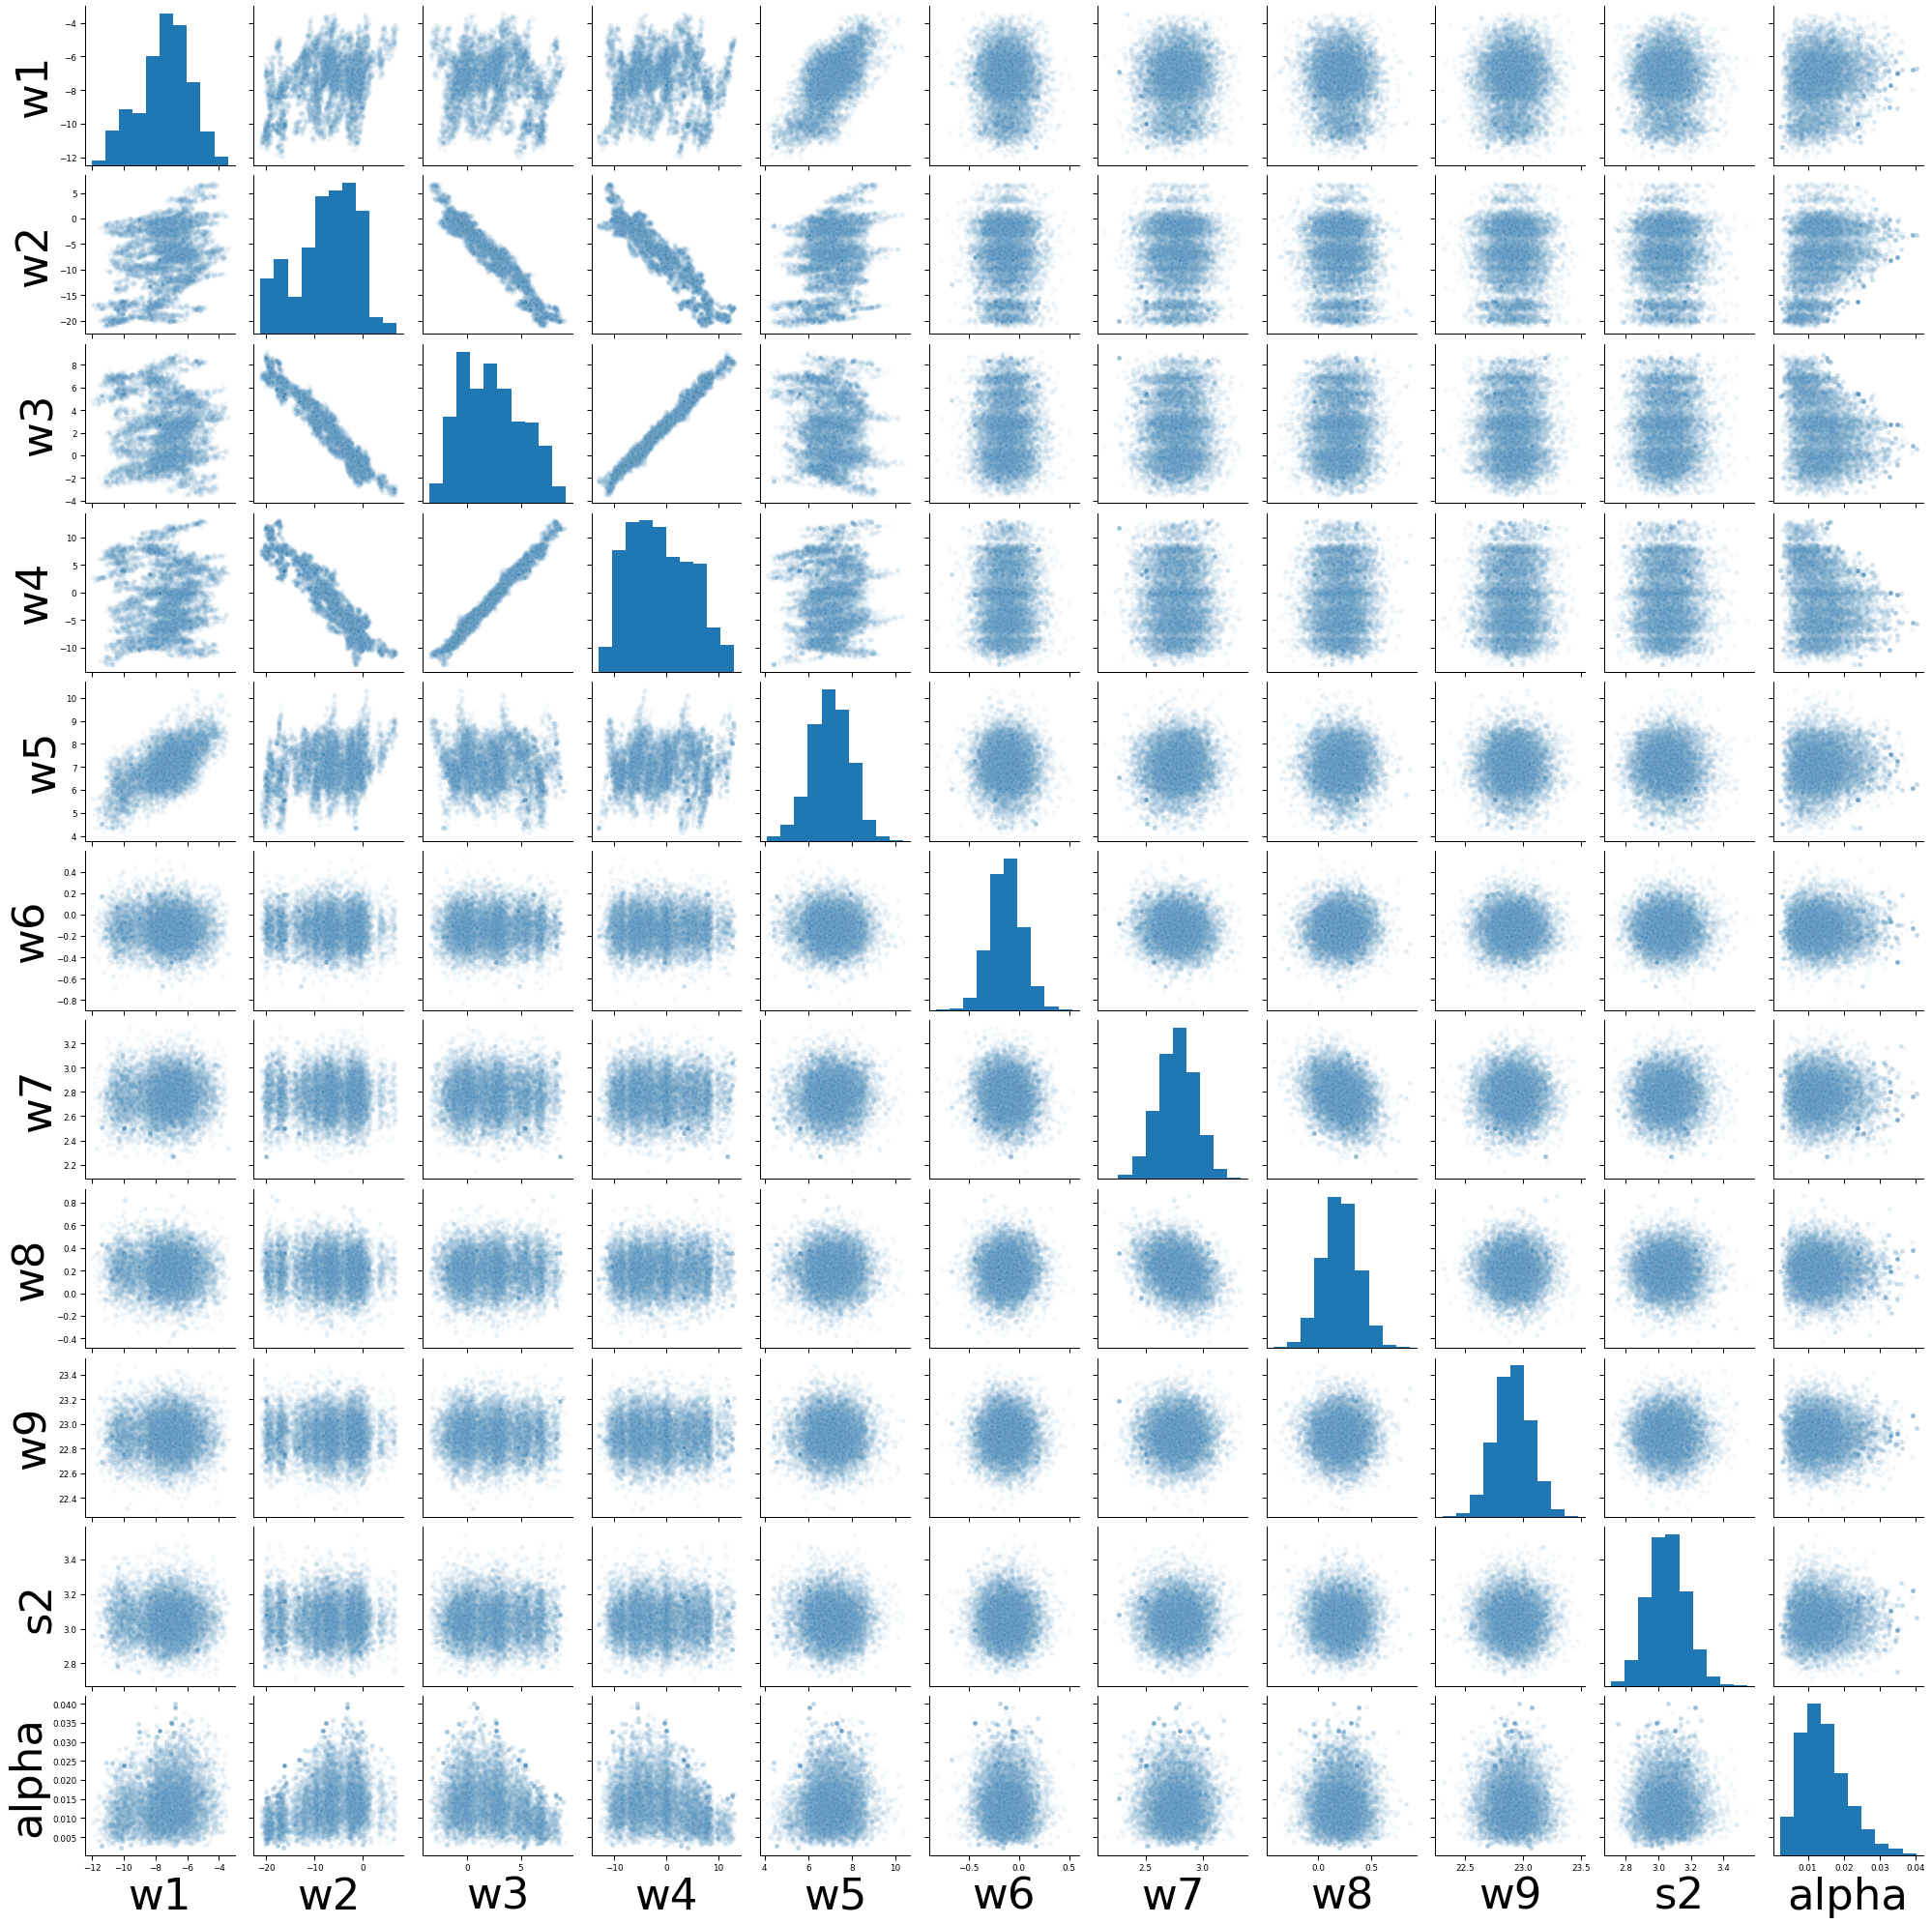

In [19]:
cols = ['w1','w2','w3','w4','w5','w6','w7','w8','w9','s2','alpha']
df_s = pd.DataFrame(S)
df_s.columns = cols
plt.rcParams['figure.figsize'] = [6, 6]

sns.set_context("paper", rc={"axes.labelsize":45})
sns.pairplot(df_s,plot_kws={'alpha':0.05})


<ipython-input-20-68d516186b93>:2: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(S[:, 9], S[:, 10], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0, markersize = 4)


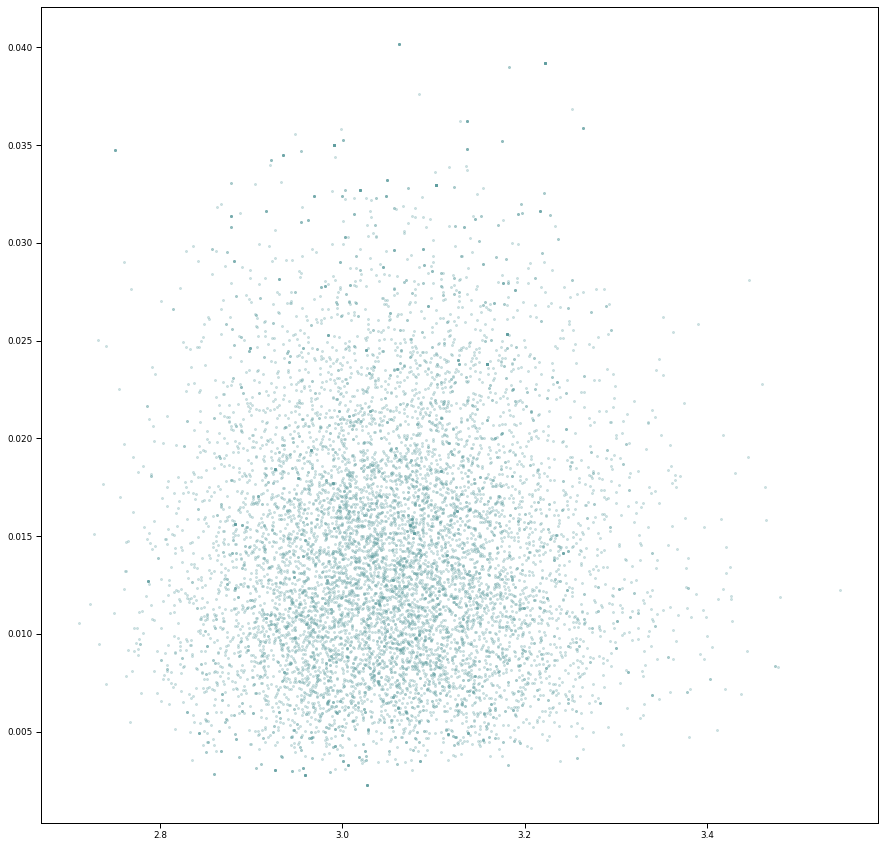

In [20]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(S[:, 9], S[:, 10], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0, markersize = 4)
#plt.contour(x[0], x[1], -z, cmap = 'inferno', levels = 14)

<ipython-input-21-6e1cc3388879>:2: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(S[:, 1], S[:, 2], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
<ipython-input-21-6e1cc3388879>:3: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(S[:, 3], S[:, 4], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
<ipython-input-21-6e1cc3388879>:4: MatplotlibDeprecationWarning: Saw kwargs ['ms', 'markersize'] which are all aliases for 'markersize'.  Kept value from 'markersize'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  plt.plot(S[:, 5], S[:, 6], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
<ipython-input-21-6e1c

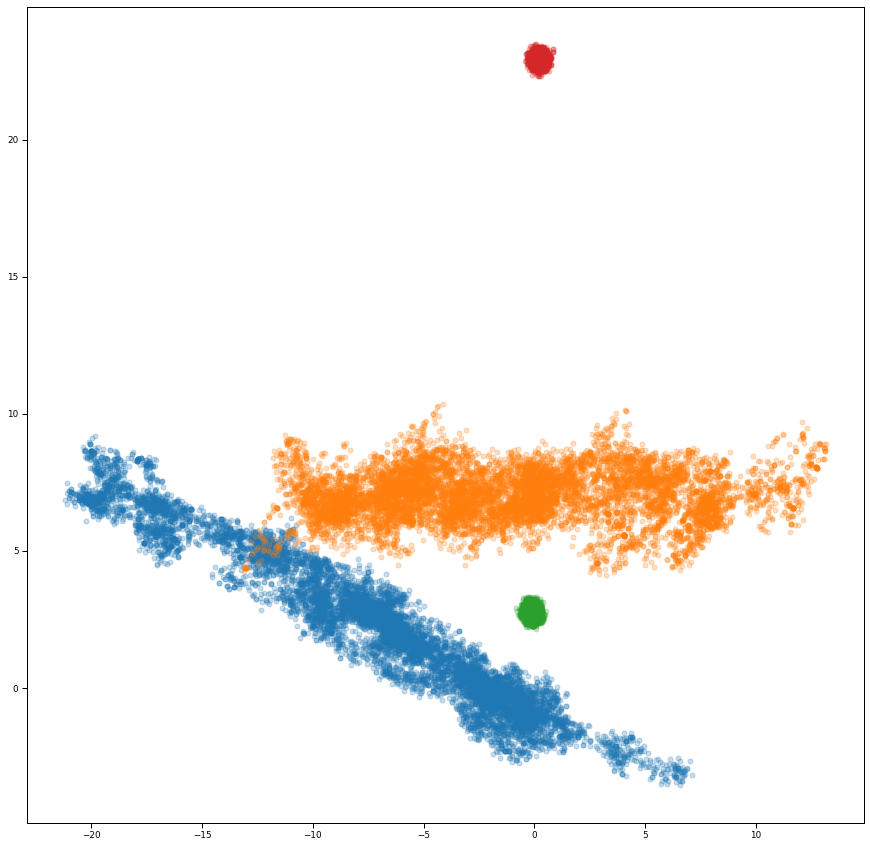

In [21]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.plot(S[:, 1], S[:, 2], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
plt.plot(S[:, 3], S[:, 4], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
plt.plot(S[:, 5], S[:, 6], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
plt.plot(S[:, 7], S[:, 8], '.', ms=6, alpha=0.25, zorder=0, markersize = 10)
#plt.contour(x[0], x[1], -z, cmap = 'inferno', levels = 14)

In [22]:
HMC_Mu = S.mean(axis = 0)[:9]
s2 = S.mean(axis = 0)[9]
alpha = S.mean(axis = 0)[10]

y_pred = x_test @ HMC_Mu
y_pred_train = x_train @ HMC_Mu

alpha, s2

(0.014474187694454934, 3.053922994499935)

In [23]:
Mu, SIGMA= compute_posterior(PHI_train, y_train, alph, s2)
y_post = PHI_test.dot(Mu[0])

In [24]:
HMC_Mu

array([-7.42279075, -7.33580835,  2.29119807, -1.14363679,  7.03680857,
       -0.12622846,  2.77064732,  0.20583646, 22.91016513])

In [25]:
Mu[0]

array([-7.23500824, -3.94104797,  0.75836566, -4.23196483,  7.21611651,
       -0.12535914,  2.77386351,  0.20429069, 22.92052084])

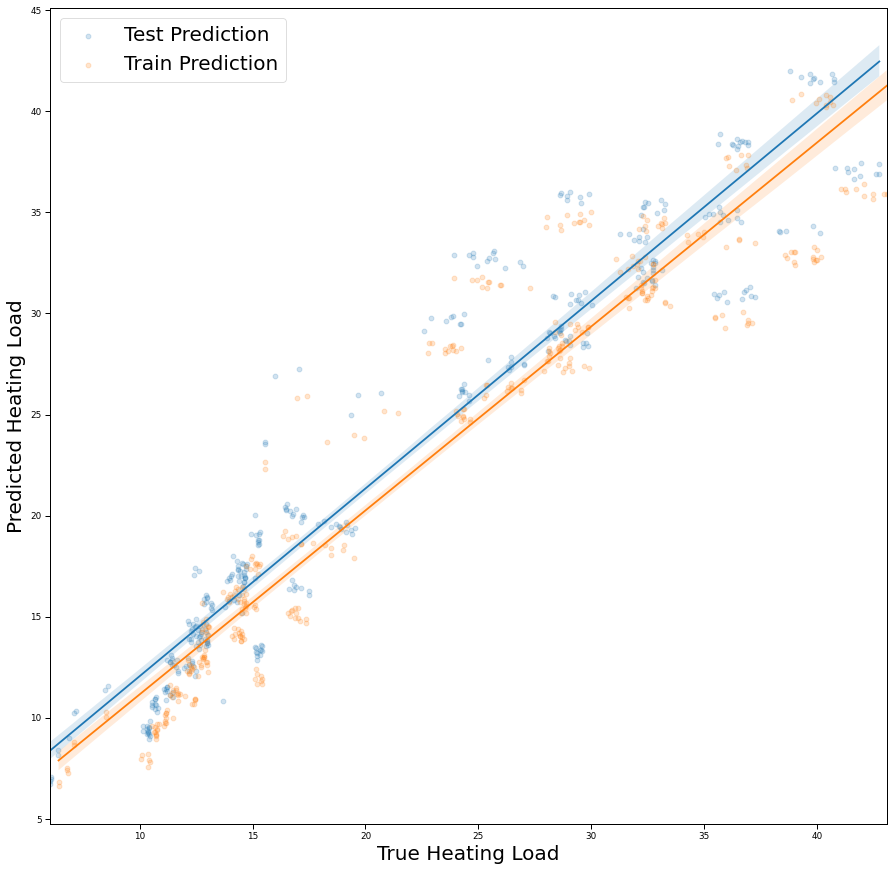

In [26]:
import seaborn as sns
sns.regplot(y_test,y_pred, label = 'Test Prediction',scatter_kws={'alpha':0.2})
sns.regplot(y_train,y_pred_train, label = 'Train Prediction',scatter_kws={'alpha':0.2})
plt.xlabel('True Heating Load', size = 20)
plt.ylabel('Predicted Heating Load', size = 20)
plt.legend(fontsize = 20)

In [27]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as MSE

r2(y_test,y_post), np.sqrt(MSE(y_test,y_post))

(0.9056179612536546, 3.095787887474643)

# Classification

In [28]:
import pandas as pd
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')



In [29]:
conditions = [
    (df_train['Heating Load'] <= 23.0),
    (df_train['Heating Load'] > 23.0) 
    ]
values = [0, 1]
df_train['bin'] = np.select(conditions, values)

conditions = [
    (df_test['Heating Load'] <= 23.0),
    (df_test['Heating Load'] > 23.0) 
    ]

values = [0, 1]

df_test['bin'] = np.select(conditions, values)

del df_train['Heating Load']
del df_test['Heating Load']

df_train.head()

Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.62         808.5      367.5      220.5             3.5   
1                  0.90         563.5      318.5      122.5             7.0   
2                  0.90         563.5      318.5      122.5             7.0   
3                  0.79         637.0      343.0      147.0             7.0   
4                  0.90         563.5      318.5      122.5             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  bin  
0            3          0.10                          5    0  
1            3          0.10                          2    1  
2            3          0.40                          2    1  
3            2          0.25                          2    1  
4            4          0.40                          5    1

In [30]:
x_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1]
x_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]

x_train, _, _ = normalize(x_train)
x_test, _, _ = normalize(x_test)

x_train['bias'] = [1]*x_train.shape[0]
x_test['bias'] = [1]*x_test.shape[0]
x_train.shape, x_test.shape


((384, 9), (384, 9))

In [31]:

def energy_func(x, x_train, y_train):
    
    w = x[:9]
    alpha = (x[9])
    
    M = x_train.shape[1]
    N = x_train.shape[0]
    
    y_post = x_train @ w
    
    a = y_post * (y_train - 1) 
    b = -np.log( 1 + np.exp(-y_post))
    
    liklihood = -np.sum(a+b)
    
    prior = (M/2.0)*np.log( (alpha/(2.0*np.pi)) ) \
            - ((alpha/2)*np.sum(w**2.0))
    
    return -(liklihood + prior)


def energy_grad(x, x_train, y_train):
    
    # define empty array
    g = np.empty(10)
    
    # collect weights, noise, and alpha parameters
    w = x[:9] 
    alpha = (x[9]) 
    
    M = x_train.shape[1]
    N = x_train.shape[0]
    
    y_post = x_train @ w
    
    # compute gradient for each weight in loop
    for i in range(x_train.shape[1]): # grad weights W
        g[i] =  np.sum(x_train[:,i] * (y_train - 1.0 + np.exp(-y_post)/(1.0 + np.exp(-y_post)) ) ) + alpha*w[i]
        
    g[9] = (-M/(2*alpha) + np.sum(0.5*w**2.0)) # grad alpha
    
    return g


In [32]:
np.random.seed(seed=100)    
x0 = np.random.uniform(0.01,1,size=10)
# initial guess for s2 and alpha are on a different scale
x0[-1:] = np.random.uniform(0.001,1,size=1)
print(x0)


hmc.gradient_check(x0, energy_func, energy_grad, x_train.values, y_train.values)

[0.54797089 0.28558569 0.43027241 0.84632837 0.01467167 0.13035343
 0.67404159 0.82759423 0.14533952 0.89143063]
Calc.         Numeric       Delta         Acc.
     185.708       185.708  -3.976575e-08  10
    -192.484      -192.484  -4.426289e-08  10
     47.1733       47.1733  -2.252735e-08  10
    -210.781      -210.781   1.731235e-08  11
      216.66        216.66   1.944491e-08  11
    -4.76016      -4.76016  -1.728558e-08   9
     -47.045       -47.045  -1.430190e-08  10
    -60.6974      -60.6974  -6.711005e-10  11
    -9.97981      -9.97981   9.002282e-09  10
    -3.81766      -3.81766   7.639922e-09   9


In [33]:
R = 10000  
burn = int(R/10) 
L = 100
eps = 0.00008 #0.00008

S, R = hmc.sample(x0, energy_func, energy_grad, R, L, eps, 
                   burn=burn, 
                   checkgrad=True, 
                   args=[x_train.values, y_train.values])

Calc.         Numeric       Delta         Acc.
     185.708       185.708  -3.976575e-08  10
    -192.484      -192.484  -4.426289e-08  10
     47.1733       47.1733  -2.252735e-08  10
    -210.781      -210.781   1.731235e-08  11
      216.66        216.66   1.944491e-08  11
    -4.76016      -4.76016  -1.728558e-08   9
     -47.045       -47.045  -1.430190e-08  10
    -60.6974      -60.6974  -6.711005e-10  11
    -9.97981      -9.97981   9.002282e-09  10
    -3.81766      -3.81766   7.639922e-09   9
|----------|  0% accepted [ 175 secs to go ]
|#---------| 100% accepted [ 158 secs to go ]
|##--------| 100% accepted [ 139 secs to go ]
|###-------| 100% accepted [ 123 secs to go ]


<ipython-input-31-19fa0bb4d782>:16: RuntimeWarning: invalid value encountered in log
  prior = (M/2.0)*np.log( (alpha/(2.0*np.pi)) ) \


|####------| 100% accepted [ 104 secs to go ]
|#####-----| 99% accepted [ 87 secs to go ]
|######----| 98% accepted [ 69 secs to go ]
|#######---| 97% accepted [ 52 secs to go ]
|########--| 94% accepted [ 35 secs to go ]
|#########-| 92% accepted [ 17 secs to go ]
|##########| 88% accepted [ 0 secs to go ]
HMC: R=10000 / L=100 / eps=8e-05 / Accept=88.5%


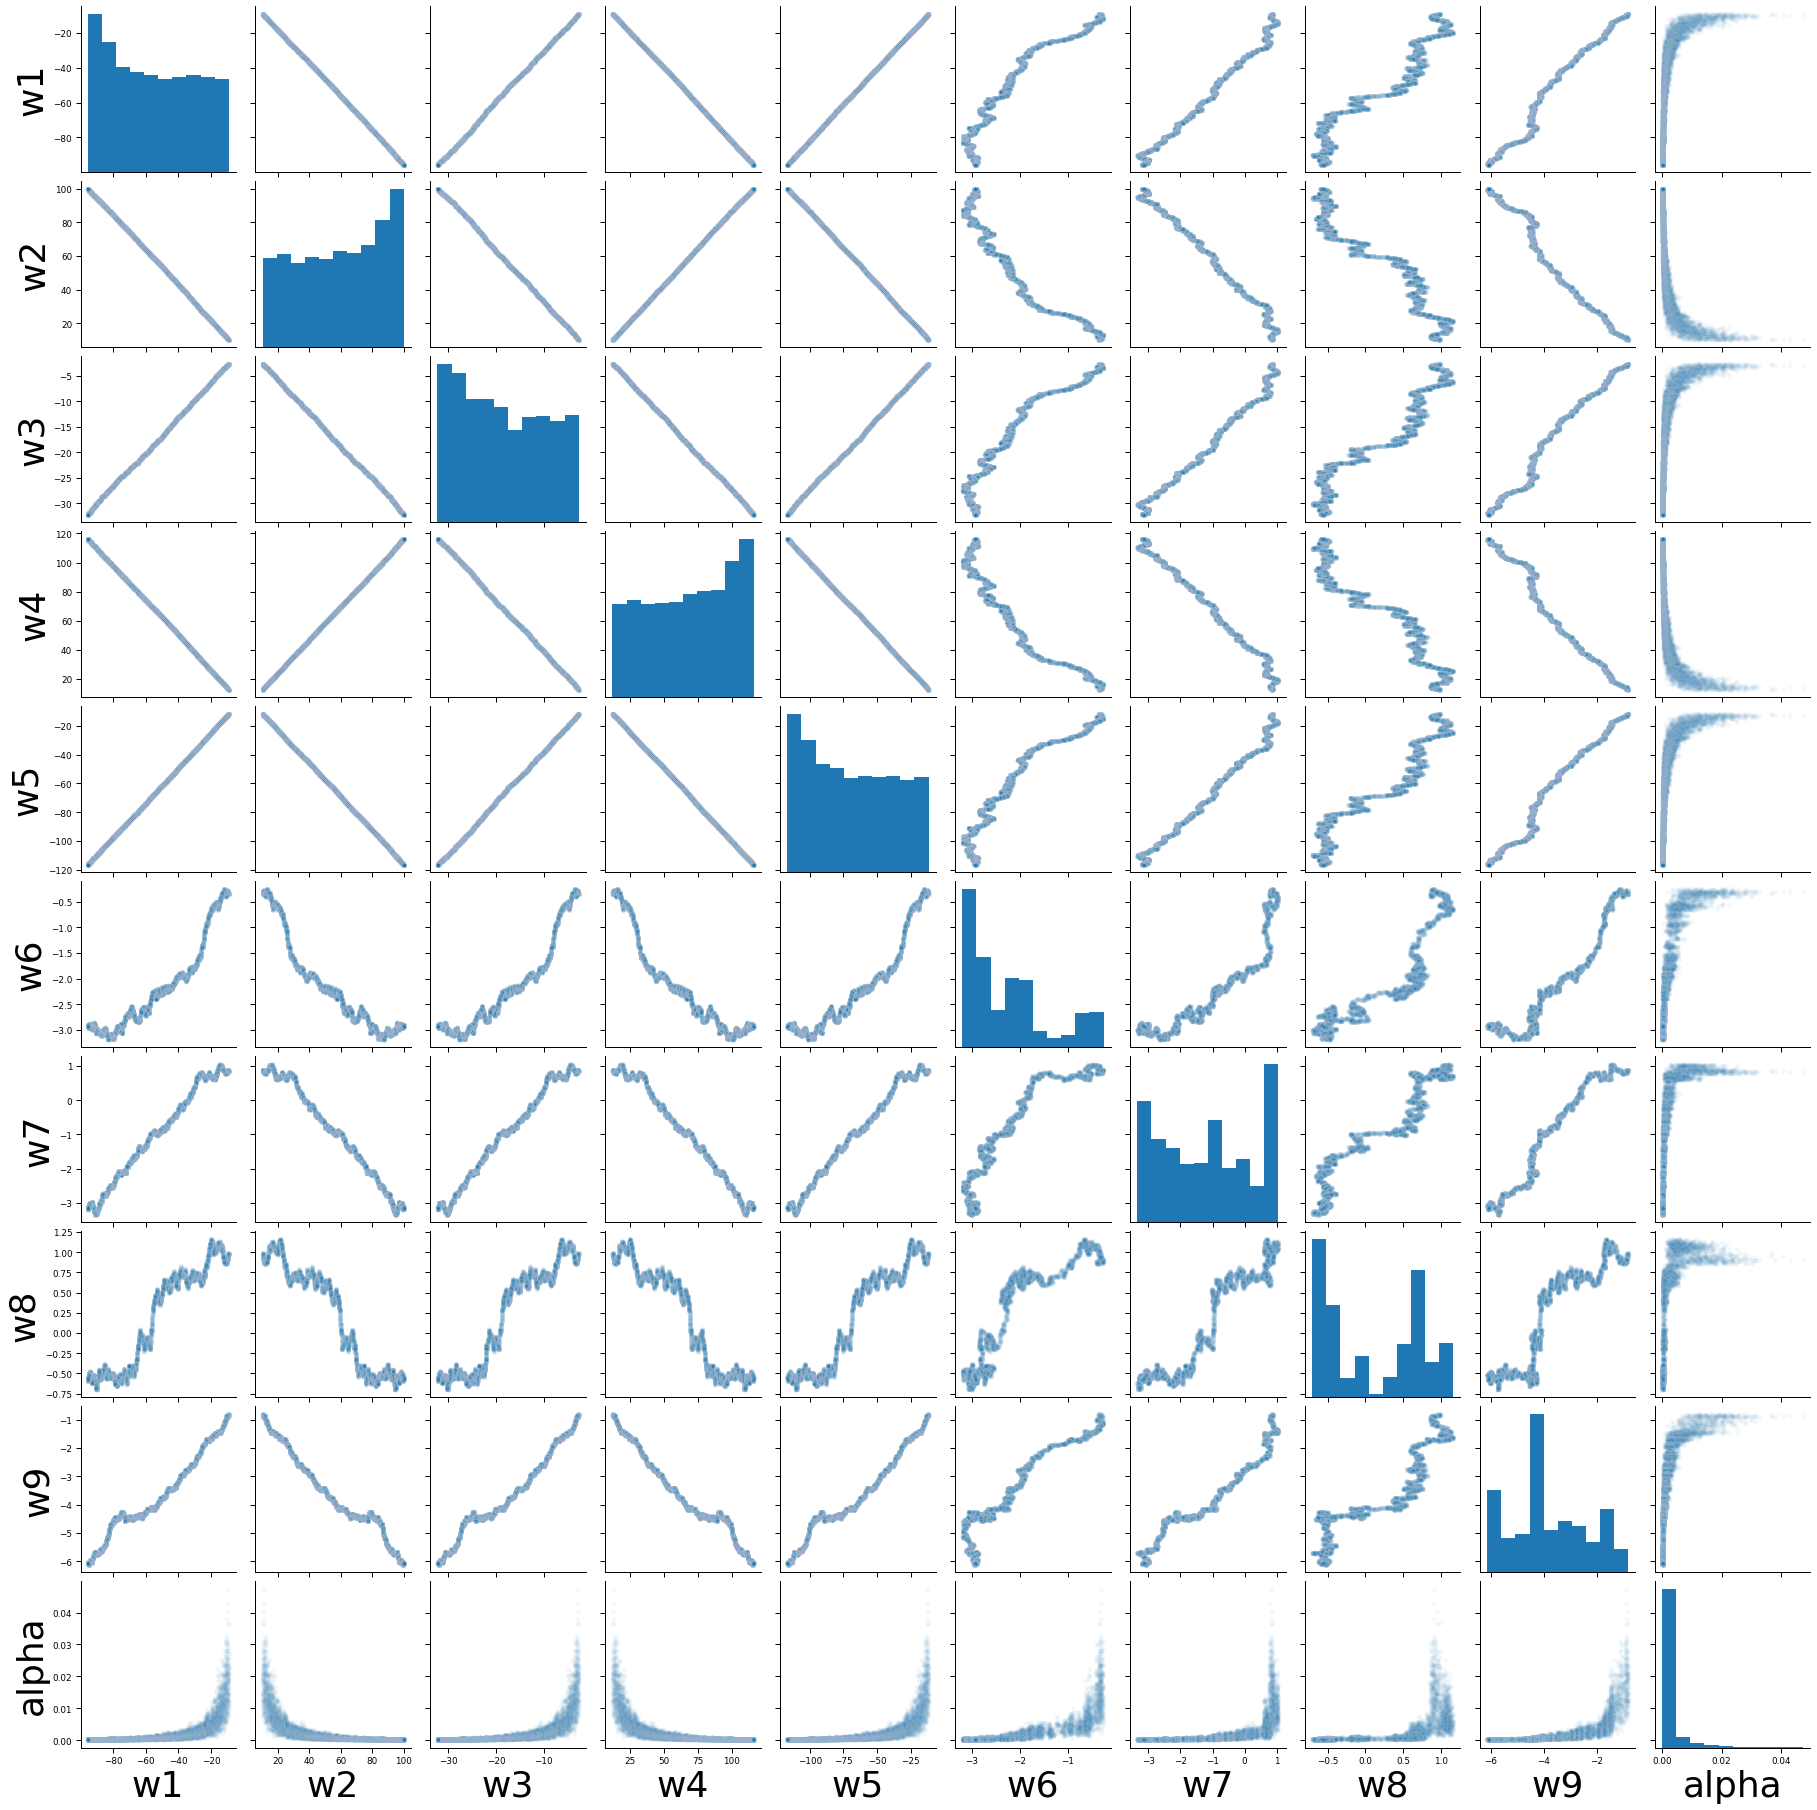

In [34]:
cols = ['w1','w2','w3','w4','w5','w6','w7','w8','w9','alpha']
df_s = pd.DataFrame(S)
df_s.columns = cols
plt.rcParams['figure.figsize'] = [6, 6]

sns.set_context("paper", rc={"axes.labelsize":36})
sns.pairplot(df_s,plot_kws={'alpha':0.05})


In [35]:

def sigmoid(x):
    return 1/(1 + np.exp(-x))

HMC_Mu = -S.mean(axis = 0)[:9]
alpha = S.mean(axis = 0)[9]

y_pred = sigmoid(x_test @ HMC_Mu)

In [36]:
HMC_Mu

array([ 55.98949486, -59.29190314,  18.64850681, -69.00719371,
        68.74702613,   2.2343952 ,   1.15152878,  -0.12240791,
         3.8031132 ])

In [37]:
print('alpha = ', HMC_Mu[-1])

alpha =  3.8031132022265055


In [38]:
acc = np.sum(y_pred.astype(int) == y_test) / y_test.shape[0]

print('HMC accuracy: ', acc)

HMC accuracy:  0.9765625


In [39]:
from sklearn.metrics import confusion_matrix as cm

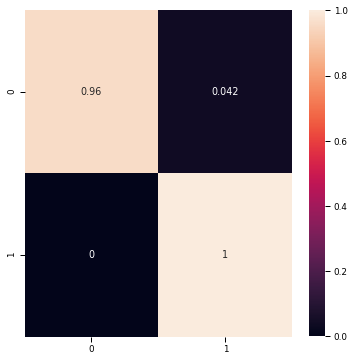

In [40]:
sns.heatmap(cm(y_test,y_pred.astype(int), normalize = 'true'), annot = True)

In [41]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

model = lr.fit(x_train,y_train)

y_pred = lr.predict(x_test)

acc = model.score(x_test,y_test)

print('Sci-kit Learn accuracy: ', acc)

Sci-kit Learn accuracy:  0.9765625


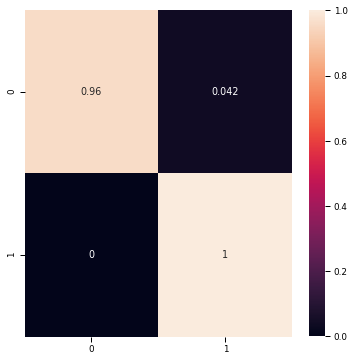

In [42]:
sns.heatmap(cm(y_test,y_pred.astype(int), normalize = 'true'), annot = True)